In [35]:
df = pd.read_csv("results/the_final_data.csv")

log2_filter = abs(df["log2_odds_ratio"]) > 0.32
sign_filter = df["p_adj"] < 0.05

df["log2_thresh"] = log2_filter
df["sign_thresh"] = sign_filter
df["both_thresh"] = log2_filter & sign_filter
df['is_gene_upregulated'] = df['log2_odds_ratio'] >= 0

import sqlite3
# add genes table
sqlite_conn = sqlite3.connect('data/mirscribe_backup.db')
genes = pd.read_sql('SELECT * FROM genes', sqlite_conn)
sqlite_conn.close()


# add genes table details
cols_to_merge = ['gene_id', 'tier_cosmic', 'is_hallmark_cosmic','is_oncogene_consensus',
       'is_tsupp_consensus']

df = pd.merge(df, genes[cols_to_merge], how="left", on="gene_id" )

dtypes = {
    'gene_id': 'string',        # More efficient than object for string data
    'tier_cosmic': 'int8',      # Small integer values
    'is_hallmark_cosmic': 'bool',
    'is_oncogene_consensus': 'bool',
    'is_tsupp_consensus': 'bool'
}

# Apply optimized dtypes:
df[cols_to_merge] = df[cols_to_merge].astype(dtypes)


In [50]:
# Define filters
up_oncogene_filter = df.both_thresh & (df.log2_odds_ratio > 0) & df.is_oncogene_consensus
up_tsupp_filter = df.both_thresh & (df.log2_odds_ratio > 0) & df.is_tsupp_consensus
down_oncogene_filter = df.both_thresh & (df.log2_odds_ratio < 0) & df.is_oncogene_consensus
down_tsupp_filter = df.both_thresh & (df.log2_odds_ratio < 0) & df.is_tsupp_consensus

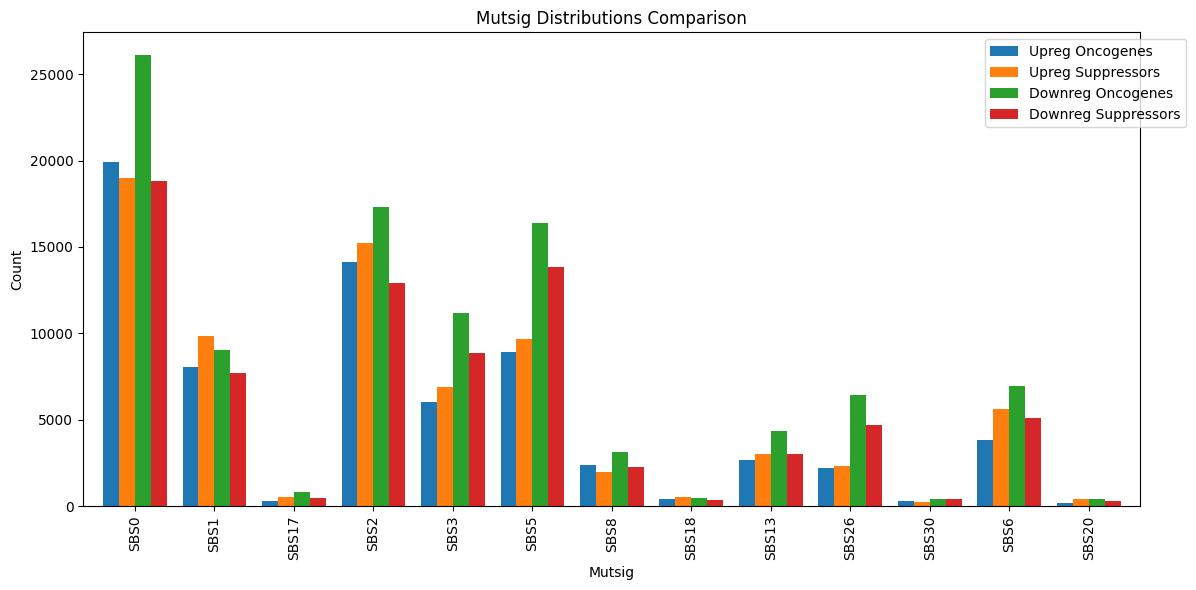

In [51]:
# Create distributions
up_onc_dist = real[real.gene_id.isin(df[up_oncogene_filter].gene_id)].mutsig.value_counts()
up_tsupp_dist = real[real.gene_id.isin(df[up_tsupp_filter].gene_id)].mutsig.value_counts()
down_onc_dist = real[real.gene_id.isin(df[down_oncogene_filter].gene_id)].mutsig.value_counts()
down_tsupp_dist = real[real.gene_id.isin(df[down_tsupp_filter].gene_id)].mutsig.value_counts()

# Plot
plot_df = pd.DataFrame({
    'Upreg Oncogenes': up_onc_dist,
    'Upreg Suppressors': up_tsupp_dist,
    'Downreg Oncogenes': down_onc_dist,
    'Downreg Suppressors': down_tsupp_dist
})

# plot_df["Upreg Oncogenes"] = plot_df["Upreg Oncogenes"] * 0.4
# plot_df["Upreg Suppressors"] = plot_df["Upreg Suppressors"] * 0.4


ax = plot_df.plot(kind='bar', width=0.8, figsize=(12,6))
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Mutsig Distributions Comparison')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [47]:
plot_df["Upreg Oncogenes"] = plot_df["Upreg Oncogenes"] * 0.4
plot_df["Upreg Suppressors"] = plot_df["Upreg Suppressors"] * 0.4


In [42]:
real.is_gene_upregulated.value_counts()

is_gene_upregulated
True     52712180
False    21984455
Name: count, dtype: int64

In [32]:
real.head()

,id,pred_difference,vcf_id,mirna_accession,gene_id,is_intron,is_gene_upregulated,mutsig,cancer_type,mirna_family,is_mirna_oncogene,is_mirna_tumor_suppressor,is_oncogene_consensus,is_tsupp_consensus
0,0,-0.416,PD10010a,MIMAT0000257,ENSG00000172987,True,True,SBS1,nnn,miR-181-5p,False,False,False,False
1,1,-0.204,PD10010a,MIMAT0000441,ENSG00000172987,True,True,SBS1,nnn,miR-9-5p,False,False,False,False
2,2,-0.285,PD10010a,MIMAT0001635,ENSG00000172987,True,True,SBS1,nnn,miR-452-5p/892-3p,False,False,False,False
3,3,-0.507,PD10010a,MIMAT0003264,ENSG00000172987,True,True,SBS1,nnn,miR-596,False,False,False,False
4,4,0.221,PD10010a,MIMAT0003284,ENSG00000172987,True,False,SBS1,nnn,miR-371b-5p/373-5p/616-5p,False,False,False,False


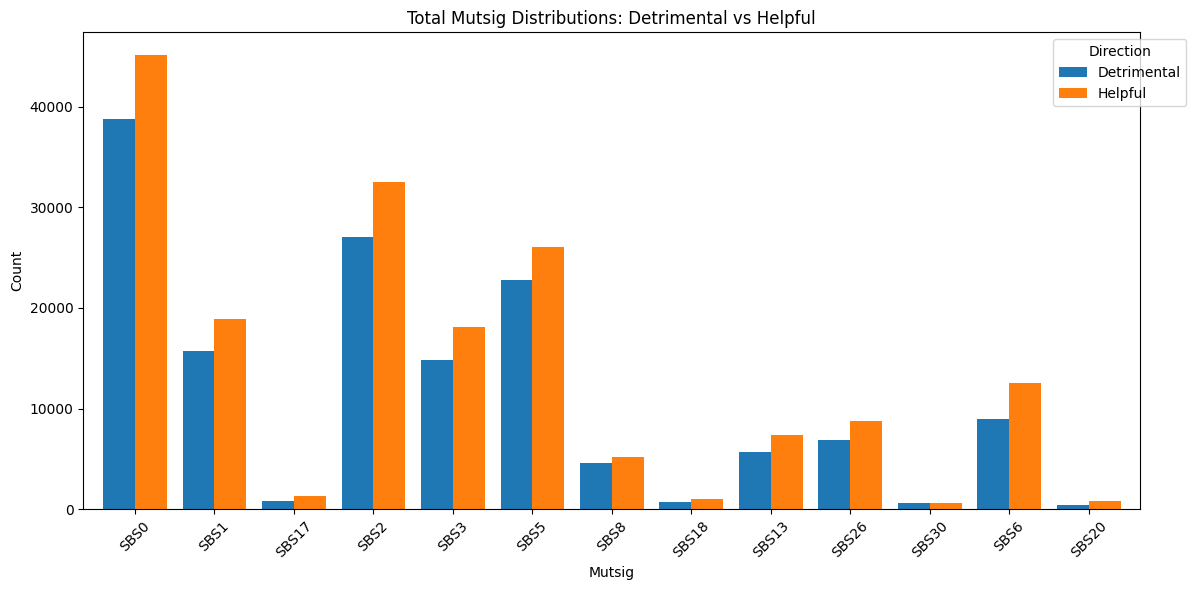

In [52]:
total_detrimental = up_onc_dist.add(down_tsupp_dist, fill_value=0)
total_helpful = down_onc_dist.add(up_tsupp_dist, fill_value=0)

# Create a summary DataFrame
updown_df = pd.DataFrame({

    'Detrimental': total_detrimental,
    'Helpful': total_helpful
})


# Plot
ax = updown_df.plot(kind='bar', width=0.8, figsize=(12,6))
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Total Mutsig Distributions: Detrimental vs Helpful')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Direction', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

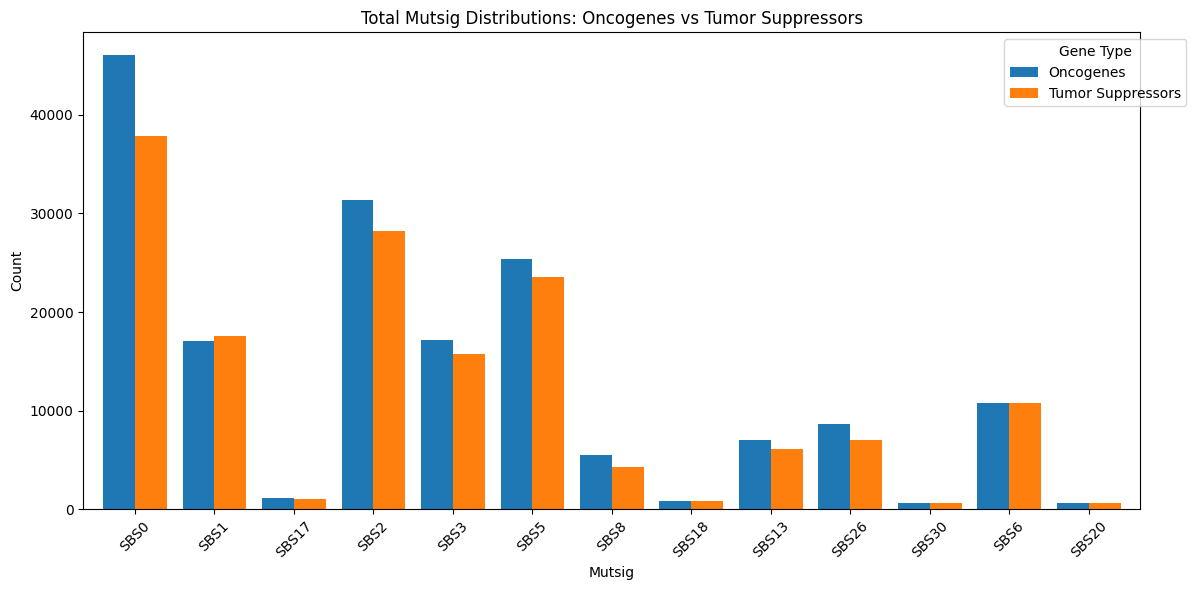

In [7]:
total_onc = up_onc_dist.add(down_onc_dist, fill_value=0)
total_tsupp = up_tsupp_dist.add(down_tsupp_dist, fill_value=0)

# Create a summary DataFrame
onctsupp_df = pd.DataFrame({
    'Oncogenes': total_onc,
    'Tumor Suppressors': total_tsupp
})

# Plot
ax = onctsupp_df.plot(kind='bar', width=0.8, figsize=(12,6))
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Total Mutsig Distributions: Oncogenes vs Tumor Suppressors')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Gene Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [8]:
up_onc_genes = df[up_oncogene_filter].gene_id.tolist()
up_tsupp_genes = df[up_tsupp_filter].gene_id.tolist()
down_onc_genes = df[down_oncogene_filter].gene_id.tolist()
down_tsupp_genes = df[down_tsupp_filter].gene_id.tolist()

upregulated_genes = up_onc_genes + up_tsupp_genes
downregulated_genes = down_onc_genes + down_tsupp_genes



# mutsig-cancer type

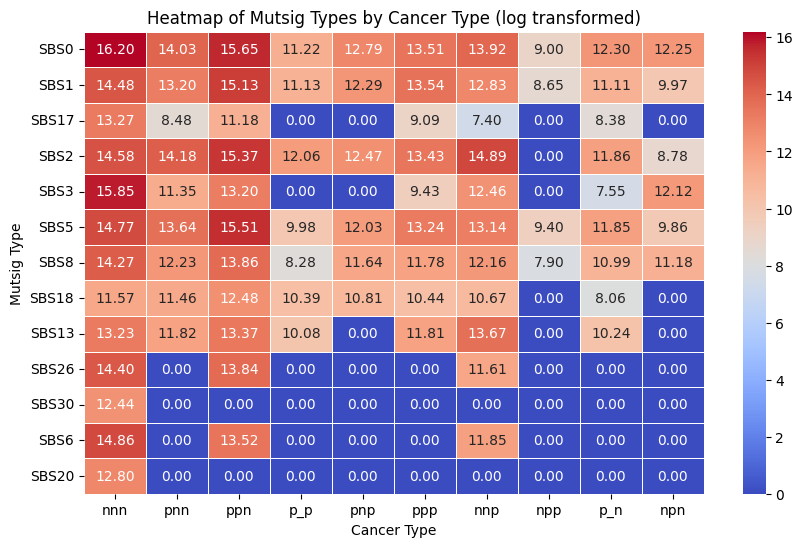

In [31]:
mutsig_type_pivot = real.pivot_table(index='mutsig', columns='cancer_type', values='id', aggfunc='count')
mutsig_type_pivot = mutsig_type_pivot[~mutsig_type_pivot.index.isin(['sbs0'])]

# Create the heatmap
plt.figure(figsize=(10, 6))


sns.heatmap(np.log1p(mutsig_type_pivot), annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)


plt.title('Heatmap of Mutsig Types by Cancer Type (log transformed)')
plt.xlabel('Cancer Type')
plt.ylabel('Mutsig Type')
plt.show()

# mirna_family based

In [14]:
(real.pivot_table(index="mirna_family", columns="mutsig", values="id", aggfunc="count")
 .assign(total=lambda df: df.sum(axis=1))
 .sort_values(by="total", ascending=False)
.assign(how_many_zeros=lambda df: (df == 0).sum(axis=1))


).head()
 

mutsig,SBS0,SBS1,SBS17,SBS2,SBS3,SBS5,SBS8,SBS18,SBS13,SBS26,SBS30,SBS6,SBS20,total,how_many_zeros
mirna_family,,,,,,,,,,,,,,,
miR-548ay-5p_long,144271,62597,4849,75381,61119,70475,25038,4859,14817,20186,1993,30411,2549,518545,0
miR-378-3p,110496,38380,3708,66103,46364,53345,17366,3062,12586,15120,1265,18284,1907,387986,0
let-7-5p/98-5p,95326,30323,2971,53410,40762,46372,16056,2515,10147,14325,1215,15724,1806,330952,0
miR-302-3p/372-3p/373-3p/520-3p,91722,33261,3126,52955,38859,45501,14754,2763,10162,12870,1136,16046,1481,324636,0
miR-17-5p/20-5p/93-5p/106-5p/519-3p,77035,28744,2628,43162,33098,39524,12108,2433,7918,11526,902,14079,1388,274545,0


In [86]:
# Creating the pivot table with total and zero count columns
pivot_table = (real[real.is_gene_upregulated].pivot_table(index="mirna_family", columns="mutsig", values="id", aggfunc="count")

               .assign(total=lambda df: df.sum(axis=1))
               .sort_values(by="total", ascending=False)
               .assign(how_many_zeros=lambda df: (df == 0).sum(axis=1)).head(20))

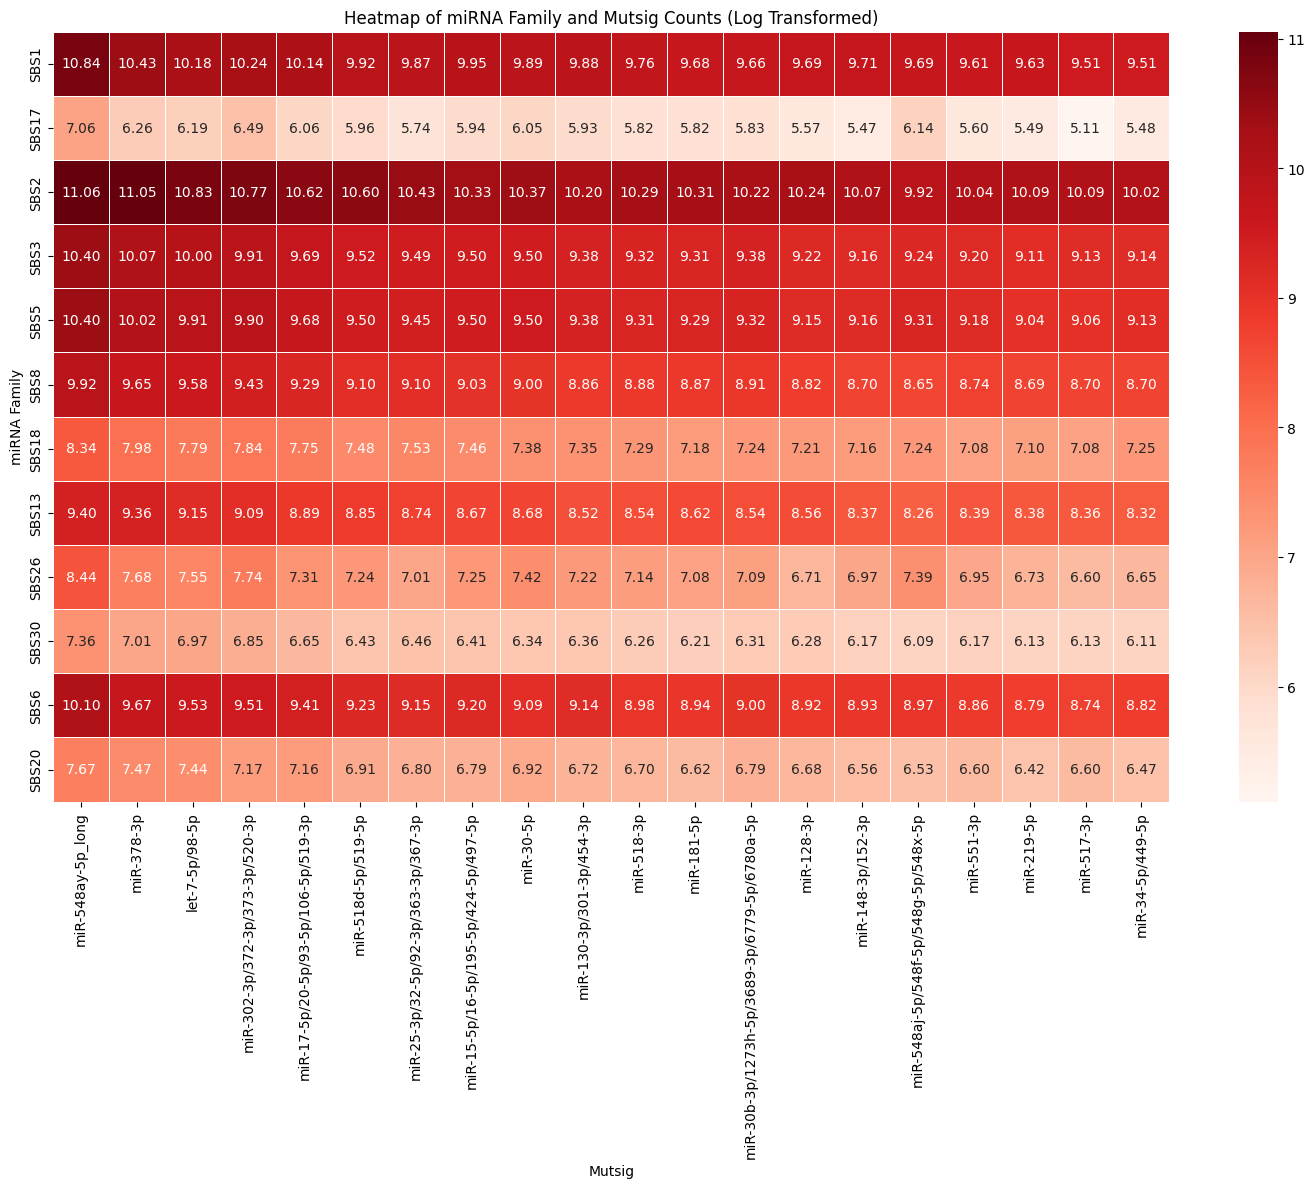

In [87]:
# # Creating the pivot table with total and zero count columns
# pivot_table = (real.pivot_table(index="mirna_family", columns="mutsig", values="id", aggfunc="count")
#                .assign(total=lambda df: df.sum(axis=1))
#                .sort_values(by="total", ascending=False)
#                .assign(how_many_zeros=lambda df: (df == 0).sum(axis=1)).head(20))

# Prepare heatmap data by dropping unnecessary columns
heatmap_data = pivot_table.drop(columns=['total', 'how_many_zeros', 'SBS0'], errors='ignore').T

# Applying log transformation (log1p handles the zeros appropriately)
heatmap_data_log = np.log1p(heatmap_data)


# Create the heatmap using the log-transformed data
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data_log, annot=True, fmt='.2f', cmap='Reds', linewidths=.5)
plt.title('Heatmap of miRNA Family and Mutsig Counts (Log Transformed)')
plt.xlabel('Mutsig')
plt.ylabel('miRNA Family')
plt.show()

In [85]:
heatmap_data

mirna_family,miR-548ay-5p_long,miR-378-3p,let-7-5p/98-5p,miR-302-3p/372-3p/373-3p/520-3p,miR-17-5p/20-5p/93-5p/106-5p/519-3p,miR-518d-5p/519-5p,miR-30-5p,miR-25-3p/32-5p/92-3p/363-3p/367-3p,miR-15-5p/16-5p/195-5p/424-5p/497-5p,miR-130-3p/301-3p/454-3p,miR-518-3p,miR-181-5p,miR-30b-3p/1273h-5p/3689-3p/6779-5p/6780a-5p,miR-128-3p,miR-548aj-5p/548f-5p/548g-5p/548x-5p,miR-148-3p/152-3p,miR-551-3p,miR-219-5p,miR-34-5p/449-5p,miR-517-3p
mutsig,,,,,,,,,,,,,,,,,,,,
SBS1,62597,38380,30323,33261,28744,24000,22969,21790,23968,23572,20386,19642,18805,17806,20475,18718,17367,16884,15449,15075
SBS17,4849,3708,2971,3126,2628,2092,2208,2146,1994,1830,1773,1587,1494,1694,1662,1418,1545,1564,1430,1298
SBS2,75381,66103,53410,52955,43162,42852,35729,35235,33243,30672,32192,33432,29964,28769,25070,25567,24548,25411,23939,25207
SBS3,61119,46364,40762,38859,33098,26094,26991,26331,26442,23720,22109,21688,21104,20265,20362,19231,18985,18430,18121,17670
SBS5,70475,53345,46372,45501,39524,30983,31831,32185,31500,28098,25926,25429,23838,23681,23836,22784,22468,21897,21383,20344
SBS8,25038,17366,16056,14754,12108,10420,9664,10052,9666,8447,8346,8492,8483,7456,7493,6913,7202,6705,6817,6671
SBS18,4859,3062,2515,2763,2433,1895,1782,1934,1871,1726,1592,1495,1512,1390,1640,1387,1266,1262,1459,1236
SBS13,14817,12586,10147,10162,7918,7623,6789,6739,6462,5876,5762,6288,5771,5523,4901,4839,4855,4690,4506,4602
SBS26,20186,15120,14325,12870,11526,8760,9224,9533,9165,7834,7253,6817,6635,7071,6530,6562,6413,6321,5950,5714


In [54]:
df.head()

,gene_id,upregulated_real,downregulated_real,upregulated_synth,downregulated_synth,log2_odds_ratio,p_value,p_adj,z_score,gene_name,biotype,log2_thresh,sign_thresh,both_thresh,is_gene_upregulated,tier_cosmic,is_hallmark_cosmic,is_oncogene_consensus,is_tsupp_consensus
0,ENSG00000198586,2741,1457,3337.6,1559.0,-0.186474,3.952448e-03,0.014360,-0.264947,TLK1,protein_coding,False,True,False,False,0,False,False,False
1,ENSG00000227367,1392,736,985.7,484.8,-0.104083,3.163041e-01,0.494740,-0.201436,SLC9B1P4,pseudogene,False,False,False,False,0,False,False,False
2,ENSG00000233080,2126,590,1833.1,636.8,0.323838,5.930840e-04,0.002862,0.128432,CTA-714B7.5,lincRNA,True,True,True,True,0,False,False,False
3,ENSG00000153827,1958,1016,2305.2,1217.4,0.025330,7.530856e-01,0.909248,-0.101676,TRIP12,protein_coding,False,False,False,True,0,False,False,False
4,ENSG00000225889,1590,881,2086.9,852.9,-0.438965,1.925104e-07,0.000003,-0.459583,AC074289.1,antisense,True,True,True,False,0,False,False,False


In [81]:
upreg_onc = df[(df.is_oncogene_consensus) & (df.is_gene_upregulated) & (df.sign_thresh)].log2_odds_ratio
donwreg_tsupp = df[(df.is_tsupp_consensus) & ~(df.is_gene_upregulated) & (df.sign_thresh)].log2_odds_ratio

downreg_onc = df[(df.is_oncogene_consensus) & ~(df.is_gene_upregulated) & (df.sign_thresh)].log2_odds_ratio
upreg_tsupp = df[(df.is_tsupp_consensus) & (df.is_gene_upregulated) & (df.sign_thresh)].log2_odds_ratio



In [82]:
plot_data = pd.DataFrame({
    'Upreg Oncogenes': upreg_onc,
    'Upreg Suppressors': upreg_tsupp,
    'Downreg Oncogenes': downreg_onc,
    'Downreg Suppressors': donwreg_tsupp
})

In [ ]:
plot_data = 

In [84]:
df

,gene_id,upregulated_real,downregulated_real,upregulated_synth,downregulated_synth,log2_odds_ratio,p_value,p_adj,z_score,gene_name,biotype,log2_thresh,sign_thresh,both_thresh,is_gene_upregulated,tier_cosmic,is_hallmark_cosmic,is_oncogene_consensus,is_tsupp_consensus
0,ENSG00000198586,2741,1457,3337.6,1559.0,-0.186474,3.952448e-03,0.014360,-0.264947,TLK1,protein_coding,False,True,False,False,0,False,False,False
1,ENSG00000227367,1392,736,985.7,484.8,-0.104083,3.163041e-01,0.494740,-0.201436,SLC9B1P4,pseudogene,False,False,False,False,0,False,False,False
2,ENSG00000233080,2126,590,1833.1,636.8,0.323838,5.930840e-04,0.002862,0.128432,CTA-714B7.5,lincRNA,True,True,True,True,0,False,False,False
3,ENSG00000153827,1958,1016,2305.2,1217.4,0.025330,7.530856e-01,0.909248,-0.101676,TRIP12,protein_coding,False,False,False,True,0,False,False,False
4,ENSG00000225889,1590,881,2086.9,852.9,-0.438965,1.925104e-07,0.000003,-0.459583,AC074289.1,antisense,True,True,True,False,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31423,ENSG00000223330,2,58,0.8,23.2,-0.360133,1.000000e+00,1.000000,-0.398814,RNU6-1052P,snRNA,True,False,False,False,0,False,False,False
31424,ENSG00000124196,0,15,9.5,6.1,-5.553658,2.482630e-04,0.001361,-4.402298,GTSF1L,protein_coding,True,True,True,False,0,False,False,False
31425,ENSG00000232925,0,35,5.8,16.3,-4.734710,2.056120e-03,0.008277,-3.771003,MRPS16P2,pseudogene,True,True,True,False,0,False,False,False
31426,ENSG00000187747,19,0,41.6,2.2,1.322613,1.000000e+00,1.000000,0.898349,OR52B6,protein_coding,True,False,False,True,0,False,False,False


<Axes: >

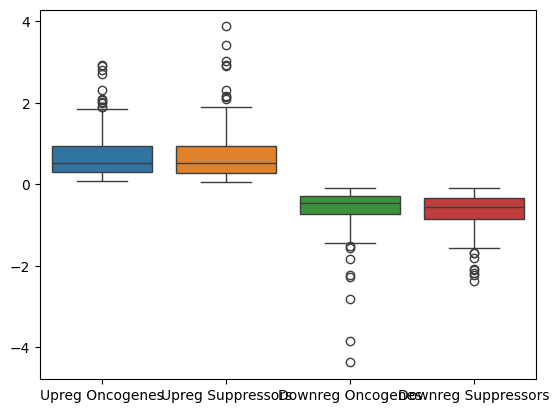

In [ ]:

sns.boxplot(plot_data, legend="auto")


In [ ]:



upreg_onc

1.0034414701834733

In [63]:
donwreg_tsupp

-0.8580484918622967

In [64]:
downreg_onc

-0.8579802285807288

In [69]:
upreg_tsupp

0.9929184193560807

In [58]:
df[(df.is_oncogene_consensus) & ~(df.is_gene_upregulated)].log2_odds_ratio.mean()


-0.4272616977868586

In [59]:
df[(df.is_tsupp_consensus) & (df.is_gene_upregulated)].log2_odds_ratio.mean()


0.4903344145501796